# Access Sample SWOT Oceanography Data in the Cloud

imported on: **2023-03-02**

<p>This notebook is from a different repository in NASA's PO.DAAC, 2022-SWOT-OCEAN-Cloud-Workshop</p>

> The original source for this document is [https://github.com/podaac/2022-SWOT-Ocean-Cloud-Workshop/blob/main/tutorials/01_Direct_Access_SWOT_sim.ipynb](https://github.com/podaac/2022-SWOT-Ocean-Cloud-Workshop/blob/main/tutorials/01_Direct_Access_SWOT_sim.ipynb)

# 01. Direct cloud data access

## Getting Started
In this notebook will show direct access of PO.DAAC archived products in the Earthdata Cloud in AWS Simple Storage Service (S3). In this demo, we will showcase the usage of **SWOT Simulated Level-2 KaRIn SSH from GLORYS for Science Version 1**. More information on the datasets can be found at https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1.

We will access the data from inside the AWS cloud (us-west-2 region, specifically) and load a time series made of multiple netCDF files into a single xarray dataset. This approach leverages S3 native protocols for efficient access to the data.

In the future, if you want to use this notebook as a reference, please note that we are not doing collection discovery here - we assume the collection of interest has been determined. 

### Requirements

This can run in the Small openscapes instance, that is, it only needs 8GB of memory and ~2 CPU.

If you want to run this in your own AWS account, you can use a *t2.large* instance, which also has 2 CPU and 8GB memory. It's improtant to note that all instances using direct S3 access to PO.DAAC or Earthdata data are required to run in us-west-2, or the Oregon region.

This instance will cost approximately $0.0832 per hour. The entire demo can run in considerably less time.

### Imports 

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

```
boto3
s3fs
xarray
matplotlib
cartopy
```

## Learning Objectives
* import needed libraries
* authenticate for NASA Earthdata archive (Earthdata Login) (here this takes place as part of obtaining the AWS credentials step)
* obtain AWS credentials for Earthdata DAAC archive in AWS S3
* access DAAC data by downloading directly into your cloud workspace from S3 within US-west 2 and operating on those files.
* access DAAC data directly from the in-region S3 bucket without moving or downloading any files to your local (cloud) workspace
* plot the first time step in the data

Note: no files are being donwloaded off the cloud, rather, we are working with the data in the AWS cloud.

In [3]:
import boto3
import json
import xarray as xr
import s3fs
import os
import requests
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from os import path
%matplotlib inline

## Get a temporary AWS Access Key based on your Earthdata Login user ID

Direct S3 access is achieved by passing NASA supplied temporary credentials to AWS so we can interact with S3 objects (i.e. data) from applicable Earthdata Cloud buckets (storage space). For now, each NASA DAAC has different AWS credentials endpoints. Below are some of the credential endpoints to various DAACs. 

The below methods (get_temp_dreds) requires the user to have a 'netrc' file in the users home directory.

In [4]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'gesdisc': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac': 'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'ghrcdaac': 'https://data.ghrc.earthdata.nasa.gov/s3credentials'
}

def get_temp_creds(provider):
    return requests.get(s3_cred_endpoint[provider]).json()

We will now get a credential for the 'PO.DAAC' provider and set up our environment to use those values.

**NOTE** if you see an error like 'HTTP Basic: Access denied.' It means the username/password you've entered is incorrect.

**NOTE2** If you get what looks like a long HTML page in your error message (e.g. <Head>...), the right netrc 'machine' might be missing.


In [5]:
creds = get_temp_creds('podaac')

os.environ["AWS_ACCESS_KEY_ID"] = creds["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = creds["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = creds["sessionToken"]

s3 = s3fs.S3FileSystem(anon=False) 

## Location of data in the PO.DAAC S3 Archive
We need to determine the path for our products of interest. We can do this through several mechanisms. Those are described in the `Finding_collection_concept_ids.ipynb` notebook, or the Pre-Workshop material, https://podaac.github.io/2022-SWOT-Ocean-Cloud-Workshop/prerequisites/01_Earthdata_Search.html.

After using the `Finding_collection_concept_ids.ipynb` guide to find our S3 location, we end up with:

```json
{
    ...
    "DirectDistributionInformation": {
        "Region": "us-west-2",
        "S3BucketAndObjectPrefixNames": [
            "podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/",
            "podaac-ops-cumulus-public/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/"
        ],
        "S3CredentialsAPIEndpoint": "https://archive.podaac.earthdata.nasa.gov/s3credentials",
        "S3CredentialsAPIDocumentationURL": "https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME"
    },
    ...
}
```



## Now that we have the S3 bucket location for the data of interest...

It's time to find our data! Below we are using a `glob` to find file names matching a pattern. Here, we want any files matching the pattern used below; here this equates, in science, terms, to Cycle 001 and the first 10 passes. This information can be gleaned from product description documents. Another way of finding specific data files would be to search on cycle/pass from CMR or Earthdata Search GUI and use the S3 links provided in the resulting metadata or access links, respectively, directly instead of doing a `glob` (essentially an 'ls').

The files we are looking at are about 11-13 MB each. So the 10 we're looking to access are about ~100 MB total.

In [6]:
s3path = 's3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_00*.nc'
remote_files = s3.glob(s3path)

In [7]:
remote_files

['podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_001_20140412T120000_20140412T125126_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_002_20140412T125126_20140412T134253_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_003_20140412T134253_20140412T143420_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_004_20140412T143420_20140412T152546_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_005_20140412T152547_20140412T161713_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_006_20140412T161714_20140412T170840_DG10_01.nc',
 'podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_

# Traditional Access: get files from S3 and store them on your running cloud instance

Here we will leverage the speed of transfering data within the cloud to our running instance (this notebook!). We will download 10 files into the 'DEMO_FILES' directory to show you cloud and traditional access.

In [8]:
%%time
for f in remote_files:
    s3.download(f, "DEMO_FILES/" + os.path.basename(f))

CPU times: user 335 ms, sys: 255 ms, total: 590 ms
Wall time: 5.34 s


In [9]:
%%time
ds = xr.open_mfdataset("DEMO_FILES/SWOT_L2_LR_SSH_Expert_001_0*.nc", combine='nested', concat_dim="num_lines", decode_times=False)

CPU times: user 1.25 s, sys: 38.7 ms, total: 1.29 s
Wall time: 2.15 s


In [10]:
ds

<xarray.Dataset>
Dimensions:                                (num_lines: 88796, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/91)
    time                                   (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_baseline_dilation      (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-10 09:54:55Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       131.81928697472432
    right_last_latitude:        77.03254381435897
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.003352810664781205

Now let's plot a variable (`ssh_karin`) from these 10 files in a chosen projection.

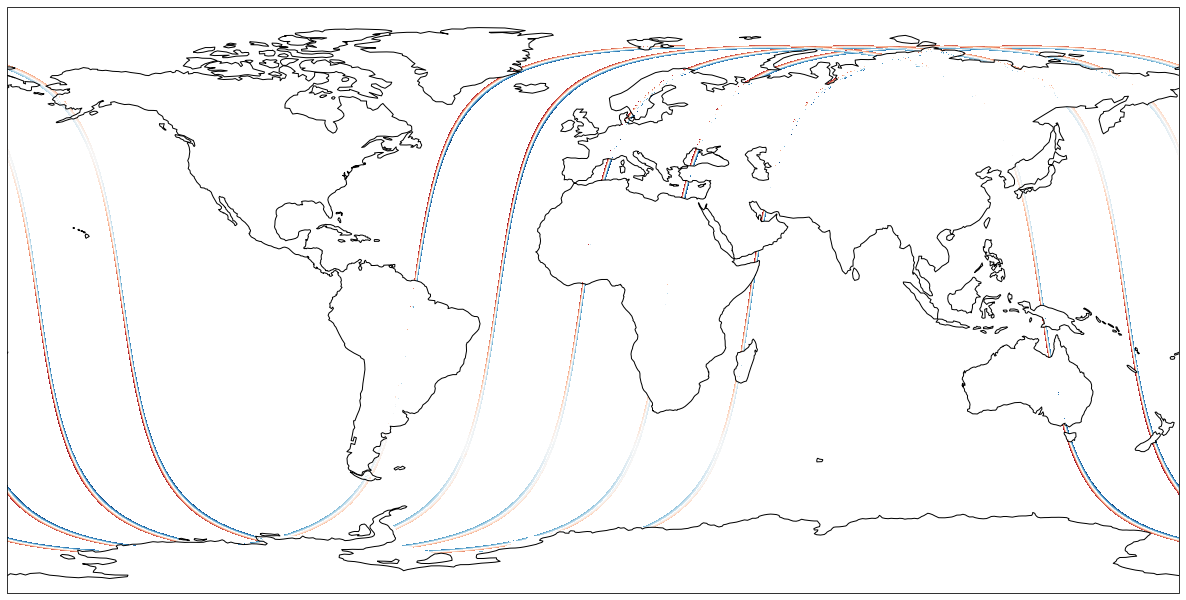

In [11]:
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([150, 180, 45, 90])
ax.set_global()
ds.ssh_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()

#ds.ssh_karin.plot()


# Access Files without any Downloads to your running instance

We can also do that same plot without 'downloading' the data to our cloud instance (i.e. disk) first. Let's try accessing the data from S3 directly through xarray (Xarray is a python package for working with labeled multi-dimensional (a.k.a. N-dimensional, ND) arrays).

In [12]:
s3path = 's3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1/SWOT_L2_LR_SSH_Expert_001_00*.nc'
remote_files = s3.glob(s3path)

In [13]:
fileset = [s3.open(file) for file in remote_files]

In [14]:
%%time
data = xr.open_mfdataset(fileset,engine='h5netcdf', combine='nested', concat_dim="num_lines", decode_times=False)

CPU times: user 5.58 s, sys: 367 ms, total: 5.95 s
Wall time: 11.4 s


In [15]:
data

<xarray.Dataset>
Dimensions:                                (num_lines: 88796, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/91)
    time                                   (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_baseline_dilation      (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-10 09:54:55Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       131.81928697472432
    right_last_latitude:        77.03254381435897
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.003352810664781205

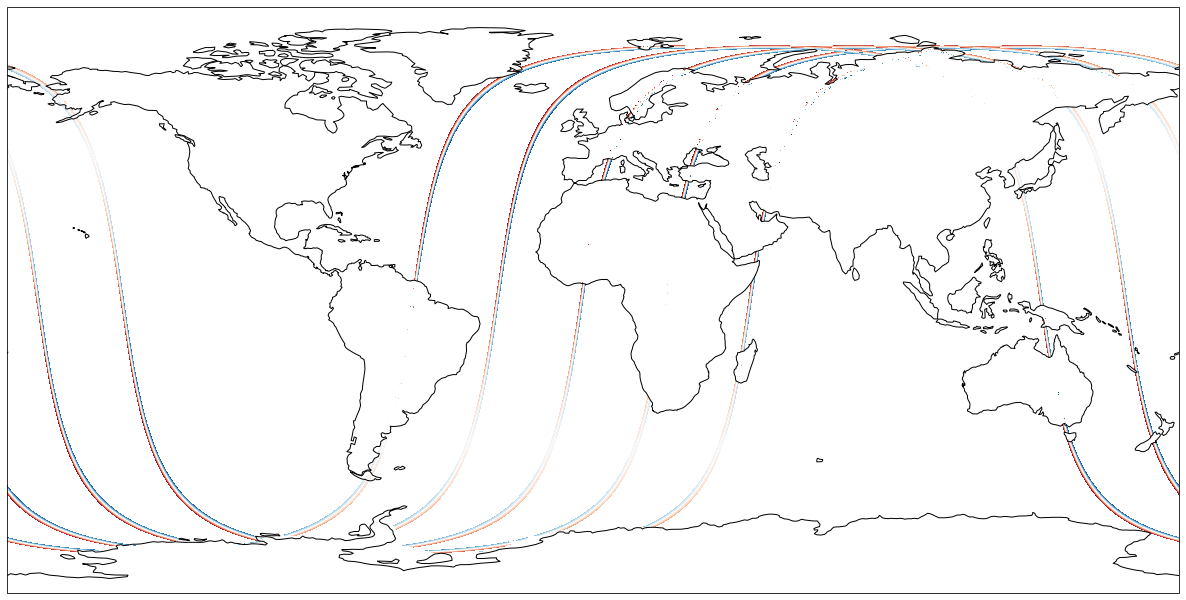

In [16]:
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
data.ssha_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()

## A final word...

Accessing data completely from S3 and in memory are affected by various things.

1. The format of the data - archive formats like NetCDF, GEOTIFF, HDF vs cloud optimized data structures (Zarr, kerchunk, COG). Cloud formats are made for accessing only the pieces of data of interest needed at the time of the request (e.g. a subset, timestep, etc).
2. The internal structure of the data. Tools like xarray make a lot of assumptions about how to open and read a file. Sometimes the internals don't fit the xarray 'mould' and we need to continue to work with data providers and software providers to make these two sides work together. Level 2 data (non-gridded), specifically, suffers from some of the assumptions made.